In [30]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from pgmpy.models import BayesianNetwork

from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator
from pgmpy.factors.discrete.CPD import TabularCPD

# Structure Learning
from pgmpy.base import DAG
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore
import networkx as nx

from sklearn.metrics import classification_report, confusion_matrix

from pgmpy.inference import VariableElimination


In [2]:
train_df = pd.read_csv('./Data/cardiovascular_train.csv')
nodes = set(train_df.columns)

In [41]:
train_df.columns

Index(['Age', 'Anxiety', 'BodyMassIndex', 'Depression', 'Diabetes',
       'EducationLevel', 'Hypercholesterolemia', 'Hypertension',
       'PhysicalActivity', 'Sex', 'SleepDuration', 'SmokerProfile',
       'SocioeconomicStatus'],
      dtype='object')

In [3]:
root_nodes = ['Age', 'Sex']
impossible_connections = []

for root_node in root_nodes:
    for node in nodes:
        connection = (node, root_node)
        impossible_connections.append(connection)

In [4]:
blacklist = set(impossible_connections)

In [5]:
def initialize_graph(nodes, p=1, blacklist=[]):
    G = DAG()
    G.add_nodes_from(nodes=nodes)
    init = G.get_random(n_nodes=len(nodes), edge_prob=p)
    ls = []
    mapping = {k: nodes[k] for k in range(len(nodes))}
    for i, j in init.edges:
        edge = (mapping[i], mapping[j])
        if edge not in blacklist:
            ls.append(edge)
    G.add_edges_from(ebunch=ls)
    return G

In [6]:
score_metric = BDeuScore(train_df)
es = HillClimbSearch(train_df)

In [7]:
rand_list = [random.randrange(3, 7) for _ in range(0,15)]
rand_list = [x/10 for x in rand_list]
best_eval = 0
for x, y in zip(range(0,15), rand_list):
    current_model = es.estimate(scoring_method=score_metric, black_list=blacklist, start_dag=initialize_graph(nodes=list(nodes), p=y, blacklist=blacklist))
    curr_eval = score_metric.score(current_model)
    print(curr_eval)
    if curr_eval < best_eval:
        best_eval = curr_eval
        best_model = current_model

print(best_eval)

  0%|          | 41/1000000 [00:01<7:31:10, 36.94it/s] 


-31740.87406429782


  0%|          | 43/1000000 [00:01<8:04:34, 34.39it/s] 


-31583.80302359296


  0%|          | 42/1000000 [00:01<7:24:26, 37.50it/s]


-31774.564660532764


  0%|          | 35/1000000 [00:01<8:10:36, 33.97it/s]


-31644.49752524252


  0%|          | 42/1000000 [00:01<7:12:00, 38.58it/s]


-31722.98084669125


  0%|          | 41/1000000 [00:01<7:24:01, 37.53it/s]


-31673.6443852191


  0%|          | 39/1000000 [00:01<7:39:59, 36.23it/s]


-31647.637305337343


  0%|          | 35/1000000 [00:01<8:24:19, 33.05it/s]


-31594.807124769082


  0%|          | 36/1000000 [00:01<8:07:29, 34.19it/s] 


-31646.993250796815


  0%|          | 37/1000000 [00:01<8:13:43, 33.76it/s]


-31628.057887707768


  0%|          | 48/1000000 [00:01<7:15:15, 38.29it/s] 


-31630.66676933132


  0%|          | 30/1000000 [00:00<8:55:52, 31.10it/s] 


-31641.583505710478


  0%|          | 37/1000000 [00:01<8:16:12, 33.59it/s]


-31649.650647144128


  0%|          | 28/1000000 [00:00<9:04:58, 30.58it/s]


-31574.353135610043


  0%|          | 36/1000000 [00:01<7:54:47, 35.10it/s]


-31628.05788770776
-31774.564660532764


In [8]:
best_model.edges

OutEdgeView([('Depression', 'SleepDuration'), ('SocioeconomicStatus', 'BodyMassIndex'), ('SocioeconomicStatus', 'EducationLevel'), ('Hypertension', 'SleepDuration'), ('Hypertension', 'Anxiety'), ('Age', 'PhysicalActivity'), ('Age', 'Hypercholesterolemia'), ('Age', 'SmokerProfile'), ('Age', 'SocioeconomicStatus'), ('Diabetes', 'PhysicalActivity'), ('Hypercholesterolemia', 'Hypertension'), ('Sex', 'PhysicalActivity'), ('Sex', 'Anxiety'), ('Sex', 'SocioeconomicStatus'), ('BodyMassIndex', 'Hypertension'), ('BodyMassIndex', 'SmokerProfile'), ('PhysicalActivity', 'SmokerProfile'), ('PhysicalActivity', 'SleepDuration'), ('PhysicalActivity', 'EducationLevel'), ('PhysicalActivity', 'Hypertension'), ('PhysicalActivity', 'Depression'), ('SmokerProfile', 'Hypercholesterolemia'), ('EducationLevel', 'BodyMassIndex'), ('EducationLevel', 'Depression')])

[('Depression', 'SleepDuration'), ('SocioeconomicStatus', 'BodyMassIndex'), ('SocioeconomicStatus', 'EducationLevel'), ('Hypertension', 'SleepDuration'), ('Hypertension', 'Anxiety'), ('Age', 'PhysicalActivity'), ('Age', 'Hypercholesterolemia'), ('Age', 'SmokerProfile'), ('Age', 'SocioeconomicStatus'), ('Diabetes', 'PhysicalActivity'), ('Hypercholesterolemia', 'Hypertension'), ('Sex', 'PhysicalActivity'), ('Sex', 'Anxiety'), ('Sex', 'SocioeconomicStatus'), ('BodyMassIndex', 'Hypertension'), ('BodyMassIndex', 'SmokerProfile'), ('PhysicalActivity', 'SmokerProfile'), ('PhysicalActivity', 'SleepDuration'), ('PhysicalActivity', 'EducationLevel'), ('PhysicalActivity', 'Hypertension'), ('PhysicalActivity', 'Depression'), ('SmokerProfile', 'Hypercholesterolemia'), ('EducationLevel', 'BodyMassIndex'), ('EducationLevel', 'Depression')]


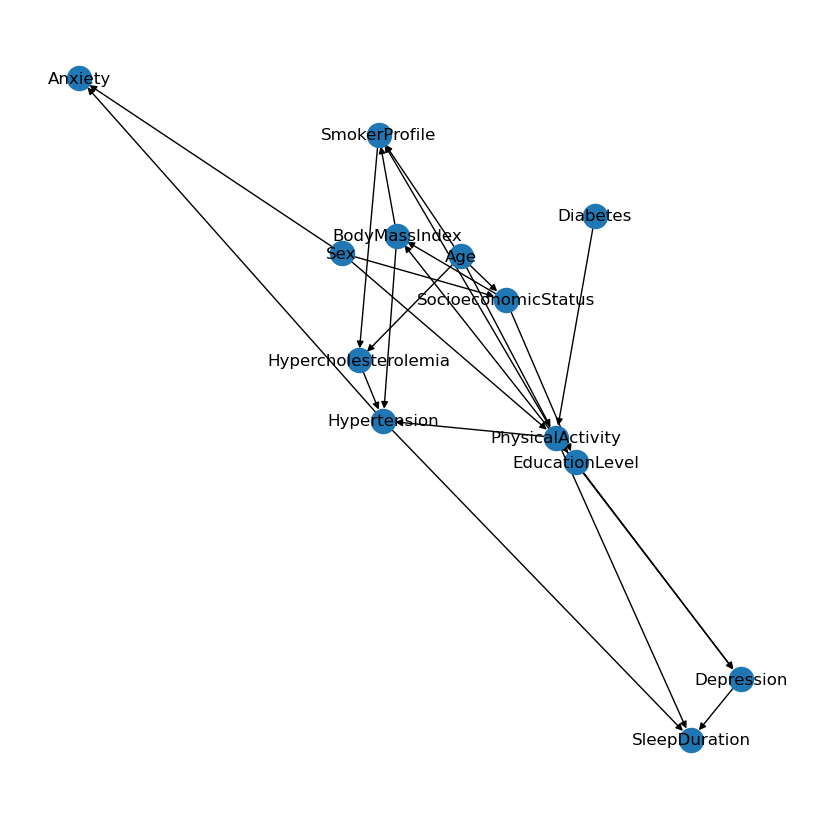

In [37]:
plt.figure(figsize=(8, 8))
nx.draw(nx.DiGraph(best_model.edges()), with_labels=True)
plt.draw()
print(best_model.edges())

In [10]:
bm = BayesianNetwork()
bm.add_nodes_from(nodes)
bm.add_edges_from(best_model.edges)

In [25]:
def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup

In [23]:
bm.fit(train_df, estimator=BayesianEstimator, prior_type='dirichlet', pseudo_counts=1)

In [27]:
for c in bm.get_cpds():
    print_full(c)


+------------------+-----------------------------------------+------------------------------------+-----------------------------------------+------------------------------------+-----------------------------------------+------------------------------------+
| EducationLevel   | EducationLevel(1)                       | EducationLevel(1)                  | EducationLevel(2)                       | EducationLevel(2)                  | EducationLevel(3)                       | EducationLevel(3)                  |
+------------------+-----------------------------------------+------------------------------------+-----------------------------------------+------------------------------------+-----------------------------------------+------------------------------------+
| PhysicalActivity | PhysicalActivity(Insufficiently Active) | PhysicalActivity(Regularly Active) | PhysicalActivity(Insufficiently Active) | PhysicalActivity(Regularly Active) | PhysicalActivity(Insufficiently Active) | Physi

In [ ]:
infer = VariableElimination(bm)

for Age in train_df['Age'].unique(): # sem relacao, justificar. # Pesquisa Cotas a dormir
    print(Age)
    print(infer.query(['SleepDuration'], evidence={'Age': Age}))

54-64
+-------------------------+----------------------+
| SleepDuration           |   phi(SleepDuration) |
+=========================+======================+
| SleepDuration(6-9hours) |               0.8916 |
+-------------------------+----------------------+
| SleepDuration(<6hours)  |               0.1055 |
+-------------------------+----------------------+
| SleepDuration(>9hours)  |               0.0029 |
+-------------------------+----------------------+
24-34
+-------------------------+----------------------+
| SleepDuration           |   phi(SleepDuration) |
+=========================+======================+
| SleepDuration(6-9hours) |               0.8904 |
+-------------------------+----------------------+
| SleepDuration(<6hours)  |               0.1068 |
+-------------------------+----------------------+
| SleepDuration(>9hours)  |               0.0028 |
+-------------------------+----------------------+
34-44
+-------------------------+----------------------+
| SleepDurati

In [44]:
for Profile in train_df['SmokerProfile'].unique():
    print(Profile, 'Diabetes')
    print(infer.query(['Diabetes'], evidence={'SmokerProfile': Profile}))

for Profile in train_df['SmokerProfile'].unique():
    print(Profile, 'Hypercholesterolemia')
    print(infer.query(['Hypercholesterolemia'], evidence={'SmokerProfile': Profile}))

for Profile in train_df['SmokerProfile'].unique():
    print(Profile, 'Hypertension')
    print(infer.query(['Hypertension'], evidence={'SmokerProfile': Profile}))

Smoker Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9491 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0509 |
+---------------+-----------------+
Non_Smoker Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9551 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0449 |
+---------------+-----------------+
Ex_Smoker Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9582 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0418 |
+---------------+-----------------+
Smoker Hypercholesterolemia
+---------------------------+-----------------------------+
| Hypercholesterolemia      |   phi(Hypercholesterolemia) |
+===========================+============

In [49]:
# Dar ganda lengalenga

for Profile in train_df['BodyMassIndex'].unique():
    print(Profile, 'Diabetes')
    print(infer.query(['Diabetes'], evidence={'BodyMassIndex': Profile}))

for Profile in train_df['BodyMassIndex'].unique():
    print(Profile, 'Hypercholesterolemia')
    print(infer.query(['Hypercholesterolemia'], evidence={'BodyMassIndex': Profile}))

for Profile in train_df['BodyMassIndex'].unique():
    print(Profile, 'Hypertension Sex')
    print(infer.query(['Hypertension'], evidence={'BodyMassIndex': Profile}))

Overweight Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9540 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0460 |
+---------------+-----------------+
Obese Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9544 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0456 |
+---------------+-----------------+
Normal Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9537 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0463 |
+---------------+-----------------+
Underweight Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9539 |
+---------------+-----------

In [57]:
for Level in train_df['EducationLevel'].unique():
    for status in train_df['SocioeconomicStatus'].unique():
        print(Level, status)
        print(infer.query(['Depression'], evidence={'EducationLevel': Level, 'SocioeconomicStatus': status}))

print("starts")
for Level in train_df['SocioeconomicStatus'].unique():
    print(Level)
    print(infer.query(['Depression'], evidence={'EducationLevel': Level, 'SocioeconomicStatus': status}))

2 3
+-----------------+-------------------+
| Depression      |   phi(Depression) |
+=================+===================+
| Depression(No)  |            0.9928 |
+-----------------+-------------------+
| Depression(Yes) |            0.0072 |
+-----------------+-------------------+
2 1
+-----------------+-------------------+
| Depression      |   phi(Depression) |
+=================+===================+
| Depression(No)  |            0.9930 |
+-----------------+-------------------+
| Depression(Yes) |            0.0070 |
+-----------------+-------------------+
2 2
+-----------------+-------------------+
| Depression      |   phi(Depression) |
+=================+===================+
| Depression(No)  |            0.9928 |
+-----------------+-------------------+
| Depression(Yes) |            0.0072 |
+-----------------+-------------------+
3 3
+-----------------+-------------------+
| Depression      |   phi(Depression) |
+=================+===================+
| Depression(No)  |     

In [58]:
df_test = pd.read_csv('./Data/cardiovascular_test.csv')

In [60]:
X_test_diabetes = df_test.drop(columns='Diabetes')
y_test_diabetes = df_test['Diabetes']

X_train_diabetes = train_df.drop(columns='Diabetes')
y_train_diabetes = df_test['Diabetes']

In [63]:
y_pred = bm.predict(X_test_diabetes)

  0%|          | 0/808 [00:00<?, ?it/s]

In [65]:
print(classification_report(y_test_diabetes, y_pred))
print(confusion_matrix(y_test_diabetes, y_pred))

              precision    recall  f1-score   support

          No       0.95      1.00      0.98      1224
         Yes       0.00      0.00      0.00        58

    accuracy                           0.95      1282
   macro avg       0.48      0.50      0.49      1282
weighted avg       0.91      0.95      0.93      1282

[[1224    0]
 [  58    0]]


/home/valentxi/miniconda3/envs/msc/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentxi/miniconda3/envs/msc/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/valentxi/miniconda3/envs/msc/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [ ]:
X_test_hypertension = df_test.drop(columns='Hypertension')
y_test_hypertension = df_test['Hypertension']
y_pred = bm.predict(X_test_hypertension)
print(classification_report(y_test_hypertension, y_pred))
print(confusion_matrix(y_test_hypertension, y_pred))


  0%|          | 0/741 [00:00<?, ?it/s]

In [69]:
X_test_cholesterolemia = df_test.drop(columns='Hypercholesterolemia')
y_test_cholesterolemia = df_test['Hypercholesterolemia']
y_pred = bm.predict(X_test_cholesterolemia)

  0%|          | 0/704 [00:00<?, ?it/s]

In [70]:
print(classification_report(y_test_cholesterolemia, y_pred))
print(confusion_matrix(y_test_cholesterolemia, y_pred))


              precision    recall  f1-score   support

          No       0.69      0.90      0.78       795
         Yes       0.68      0.34      0.45       487

    accuracy                           0.69      1282
   macro avg       0.69      0.62      0.62      1282
weighted avg       0.69      0.69      0.66      1282

[[718  77]
 [322 165]]
